train data:  (500, 3, 32, 32)
train label:  (500,)
test data:  (250, 3, 32, 32)
test label:  (250,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 30, 30]             280
             ReLU6-2           [-1, 10, 30, 30]               0
            Conv2d-3           [-1, 10, 28, 28]             910
             ReLU6-4           [-1, 10, 28, 28]               0
         MaxPool2d-5           [-1, 10, 14, 14]               0
            Conv2d-6           [-1, 10, 12, 12]             910
             ReLU6-7           [-1, 10, 12, 12]               0
            Conv2d-8            [-1, 5, 10, 10]             455
             ReLU6-9            [-1, 5, 10, 10]               0
AdaptiveMaxPool2d-10              [-1, 5, 3, 3]               0
           Linear-11                    [-1, 5]             230
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0

[87,100]	loss:0.0823	Accuracy : 0.9740		val-loss : 8.2737	val-Accuracy : 0.4960
[88,100]	loss:0.0600	Accuracy : 0.9860		val-loss : 8.0286	val-Accuracy : 0.5200
[89,100]	loss:0.0562	Accuracy : 0.9840		val-loss : 8.2153	val-Accuracy : 0.5160
[90,100]	loss:0.0504	Accuracy : 0.9860		val-loss : 8.2712	val-Accuracy : 0.5400
[91,100]	loss:0.0440	Accuracy : 0.9900		val-loss : 8.4679	val-Accuracy : 0.5520
[92,100]	loss:0.0503	Accuracy : 0.9860		val-loss : 8.6776	val-Accuracy : 0.5360
[93,100]	loss:0.0396	Accuracy : 0.9940		val-loss : 8.0716	val-Accuracy : 0.5280
[94,100]	loss:0.0528	Accuracy : 0.9840		val-loss : 8.1604	val-Accuracy : 0.5400
[95,100]	loss:0.0477	Accuracy : 0.9860		val-loss : 9.0913	val-Accuracy : 0.5240
[96,100]	loss:0.2324	Accuracy : 0.9480		val-loss : 7.7805	val-Accuracy : 0.5560
[97,100]	loss:0.2016	Accuracy : 0.9320		val-loss : 7.0433	val-Accuracy : 0.5240
[98,100]	loss:0.1637	Accuracy : 0.9500		val-loss : 9.2363	val-Accuracy : 0.4920
[99,100]	loss:0.1108	Accuracy : 0.9600		

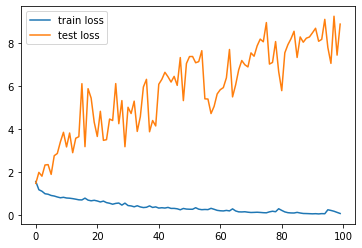

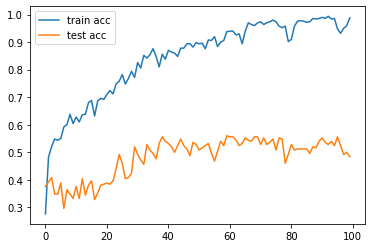

In [6]:
import matplotlib.pyplot as plt
from scipy import signal as sg
import numpy as np
import itertools
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchsummary import summary


train_dir='./texture_data/train'
test_dir='./texture_data/test'
classes=['brick','grass','ground','water','wood']
    
X_train=[]
Y_train=[]
    
PATCH_SIZE=32
np.random.seed(1234)
for idx,texture_name in enumerate(classes):
    image_dir=os.path.join(train_dir,texture_name)
    for image_name in os.listdir(image_dir):
        image=cv2.imread(os.path.join(image_dir,image_name))
        image_s=cv2.resize(image,(192,192),interpolation=cv2.INTER_LINEAR)
        for _ in range(10):
            h=np.random.randint(192-PATCH_SIZE)
            w=np.random.randint(192-PATCH_SIZE)
            image_p=image_s[h:h+PATCH_SIZE,w:w+PATCH_SIZE]
            X_train.append(image_p)
            Y_train.append(idx)
X_train=np.array(X_train)/128-1
X_train=np.swapaxes(X_train,1,3)
Y_train=np.array(Y_train)
print('train data: ',X_train.shape)
print('train label: ',Y_train.shape)

X_test=[]
Y_test=[]

for idx,texture_name in enumerate(classes):
    image_dir=os.path.join(test_dir,texture_name)
    for image_name in os.listdir(image_dir):
        image=cv2.imread(os.path.join(image_dir,image_name))
        X_test.append(image)
        Y_test.append(idx)
X_test=np.array(X_test)/128-1
X_test=np.swapaxes(X_test,1,3)
Y_test=np.array(Y_test)
print('test data: ',X_test.shape)
print('test label: ',Y_test.shape)

class Dataset(Dataset):
    def __init__(self,images,labels):
        self.images=images
        self.labels=labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx=idx.tolist()
        image=self.images[idx]
        label=self.labels[idx]
        sample=(image,label)
        return sample
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=10,kernel_size=3)
        self.conv2=nn.Conv2d(in_channels=10,out_channels=10,kernel_size=3)
        self.pool1=nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3=nn.Conv2d(in_channels=10,out_channels=10,kernel_size=3)
        self.conv4=nn.Conv2d(in_channels=10,out_channels=5,kernel_size=3)
        self.pool2=nn.AdaptiveMaxPool2d(output_size=3)
        self.fc1=nn.Linear(45,5)
        self.relu=nn.ReLU6()
    def forward(self,x):
        out=self.conv1(x)
        out=self.relu(out)
        out=self.conv2(out)
        out=self.relu(out)
        out=self.pool1(out)
        out=self.conv3(out)
        out=self.relu(out)
        out=self.conv4(out)
        out=self.relu(out)
        out=self.pool2(out)
        out=torch.flatten(out,1)
        out=self.fc1(out)
        return out
device=torch.device('cpu')
batch_size=10
learning_rate=0.004
n_epoch=100
Train_data=Dataset(images=X_train,labels=Y_train)
Test_data=Dataset(images=X_test,labels=Y_test)
Trainloader=DataLoader(Train_data,batch_size=batch_size,shuffle=True)
Testloader=DataLoader(Test_data,batch_size=batch_size)
net=CNN()
net.to(device)
summary(net, (3,32,32), device='cpu')
optimizer=optim.Adam(net.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()
train_losses=[]
train_accs=[]
test_losses=[]
test_accs=[]
#Train
for epoch in range(n_epoch):
    train_loss=0.0
    evaluation=[]
    net.train()
    for i,data in enumerate(Trainloader,0):
        features,labels=data
        labels=labels.long().to(device)
        features=features.to(device)
        optimizer.zero_grad()
        outputs=net(features.to(torch.float))
        _, predicted=torch.max(outputs.cpu().data,1)
            
        evaluation.append((predicted==labels.cpu()).tolist())
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
            
        train_loss+=loss.item()
    train_loss=train_loss/(i+1)
    evaluation=[item for sublist in evaluation for item in sublist]
    train_acc=sum(evaluation)/len(evaluation)
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    #Test
    if(epoch+1)%1==0:
        test_loss=0.0
        evaluation=[]
        net.eval()
        for i,data in enumerate(Testloader,0):
            features,labels=data
            labels=labels.long().to(device)
            features=features.to(device)
            outputs=net(features.to(torch.float))
            _, predicted=torch.max(outputs.cpu().data,1)

            evaluation.append((predicted==labels.cpu()).tolist())
            loss=criterion(outputs,labels)
            test_loss+=loss.item()
        test_loss=test_loss/(i+1)
        evaluation=[item for sublist in evaluation for item in sublist]
        test_acc=sum(evaluation)/len(evaluation)

        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print('[%d,%3d]\tloss:%.4f\tAccuracy : %.4f\t\tval-loss : %.4f\tval-Accuracy : %.4f' % (epoch+1,n_epoch,train_loss,train_acc,test_loss,test_acc))

plt.plot(range(len(train_losses)),train_losses,label='train loss')
plt.plot(range(len(test_losses)),test_losses,label='test loss')
plt.legend()
plt.show()
plt.plot(range(len(train_accs)),train_accs,label='train acc')
plt.plot(range(len(test_accs)),test_accs,label='test acc')
plt.legend()
plt.show()  